# Predicting car prices

In [92]:
import pandas as pd

cars = pd.read_csv("imports-85.data")
print(cars.columns.values.tolist())

['3', '?', 'alfa-romero', 'gas', 'std', 'two', 'convertible', 'rwd', 'front', '88.60', '168.80', '64.10', '48.80', '2548', 'dohc', 'four', '130', 'mpfi', '3.47', '2.68', '9.00', '111', '5000', '21', '27', '13495']


The dataset is missing it headers, so we are going to add them manually 

In [93]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv("imports-85.data", names = cols)
print(cars.head())

   symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...    engine-size  \
0  convertible          rwd           front        88.6  ...            130   
1  convertible          rwd           front        88.6  ...            130   
2    hatchback          rwd           front        94.5  ...            152   
3        sedan          fwd           front        99.8  ...            109   
4        sedan          4wd           front        99.4  ...            136   

   fuel-system  bore  stroke compressi

We will only use numeric values as features to be compared by our regression model. This means the columns `normalized-losses`, `wheel-base`, `length`, `width`, `height`, `curb-weight`, `bore`, `stroke`, `compression-rate`, `horsepower`, `peak-rpm`, `city-mpg`, and `highway-mpg`.

Our target value will be of course the `price` column 

## Clean up the data

In [94]:
import numpy as np

continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

numeric_cars = numeric_cars.replace("?", np.nan)
numeric_cars = numeric_cars.astype("float")
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Data missing the target column won't help us train or test our model, so lets drop those rows

In [95]:
numeric_cars = numeric_cars.dropna(subset = ["price"])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [96]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [97]:
price_col = numeric_cars["price"]
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars["price"] = price_col

## Univariate model

In [98]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(training_col, testing_col, df):
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    random_df = df.reindex(shuffled_index)
    
    #Train with 75% of the data
    last_train_index = int (len(df) / 4 * 3)
    train_df = random_df.iloc[:last_train_index]
    test_df = random_df.iloc[last_train_index:]
    knn = KNeighborsRegressor()
    knn.fit(train_df[[training_col]], train_df[testing_col])
    predictions = knn.predict(test_df[[training_col]])
    
    return mean_squared_error(test_df[testing_col], predictions) ** .5

In [99]:
continuous_values_cols.remove("price")
rmses = {}
for col in continuous_values_cols:
    rmses[col] = knn_train_test(col, "price", numeric_cars)

from operator import itemgetter
sorted(rmses.items(), key=itemgetter(1))

[('city-mpg', 3684.8035537602168),
 ('width', 3917.2276702270137),
 ('curb-weight', 4011.4500359082417),
 ('wheel-base', 4161.9479718978127),
 ('highway-mpg', 4323.5025303792845),
 ('horsepower', 4756.9837553461812),
 ('length', 5416.2940636854019),
 ('compression-rate', 5958.5723282165691),
 ('normalized-losses', 6231.311123986794),
 ('peak-rpm', 6326.4717438928401),
 ('bore', 6507.4219534313279),
 ('height', 6666.6676776273735),
 ('stroke', 6939.6914399959405)]

At 5 nearest neighbors, the citi miles per gallon feature would give us the best prediction model. However, with a RMSE of more than 3 thousand dollars the model is really poor

## Hyperparameter selection

In [100]:
def knn_train_test(training_col, testing_col, df, k):
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    random_df = df.reindex(shuffled_index)
    
    #Train with 75% of the data
    last_train_index = int (len(df) / 4 * 3)
    train_df = random_df.iloc[:last_train_index]
    test_df = random_df.iloc[last_train_index:]
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train_df[[training_col]], train_df[testing_col])
    predictions = knn.predict(test_df[[training_col]])
    
    return mean_squared_error(test_df[testing_col], predictions) ** .5

In [101]:
import collections
k_values = [1, 3, 5, 7, 9]
rmses = {}
for col in continuous_values_cols:
    col_rmses = {}
    for k in k_values:
        col_rmses[k] = knn_train_test(col, "price", numeric_cars, k)
    rmses[col] = collections.OrderedDict(sorted(col_rmses.items()))
print(rmses)    

{'length': OrderedDict([(1, 5297.150036557764), (3, 5507.6254401608267), (5, 5416.2940636854019), (7, 5030.5838284499359), (9, 4407.8270476521693)]), 'peak-rpm': OrderedDict([(1, 7434.7067165278495), (3, 7452.9880963456635), (5, 6326.4717438928401), (7, 6746.2355946023081), (9, 6817.3645171233056)]), 'curb-weight': OrderedDict([(1, 3906.6625644092765), (3, 4156.2816516395987), (5, 4011.4500359082417), (7, 3811.5247071791855), (9, 3914.8184777366964)]), 'highway-mpg': OrderedDict([(1, 5033.2242638487787), (3, 4465.3959667014478), (5, 4323.5025303792845), (7, 3902.7625529383477), (9, 4249.080449511941)]), 'normalized-losses': OrderedDict([(1, 6499.8764256729992), (3, 6373.1071234843839), (5, 6231.311123986794), (7, 6434.3319528815073), (9, 6534.5183710109532)]), 'wheel-base': OrderedDict([(1, 2740.6257228854101), (3, 3417.1446705321687), (5, 4161.9479718978127), (7, 4572.0804969760029), (9, 4488.4964112595771)]), 'width': OrderedDict([(1, 2791.7330129663678), (3, 4083.1054993128109), (5,

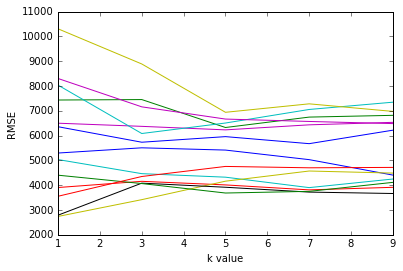

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

for k,v in rmses.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

Using `k = 1` the best price prediction can be obtain with either the wheelbase or the width of the car. Interestingly this 2 metrics are closely related to the size of a car

## Multivariate model

In [104]:
def knn_train_test(training_cols, testing_col, df, k):
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    random_df = df.reindex(shuffled_index)
    
    #Train with 75% of the data
    last_train_index = int (len(df) / 4 * 3)
    train_df = random_df.iloc[:last_train_index]
    test_df = random_df.iloc[last_train_index:]
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train_df[training_cols], train_df[testing_col])
    predictions = knn.predict(test_df[training_cols])
    
    return mean_squared_error(test_df[testing_col], predictions) ** .5

rmses = {}

two_best_features = ["city-mpg", "width"]
rmse_val = knn_train_test(two_best_features, 'price', numeric_cars, 5)
rmses["two best features"] = rmse_val

three_best_features = ["city-mpg", "width", "curb-weight"]
rmse_val = knn_train_test(three_best_features, 'price', numeric_cars, 5)
rmses["three best features"] = rmse_val

four_best_features = ["city-mpg", "width", "curb-weight", "wheel-base"]
rmse_val = knn_train_test(four_best_features, 'price', numeric_cars, 5)
rmses["four best features"] = rmse_val

five_best_features = ["city-mpg", "width", "curb-weight", "wheel-base", "highway-mpg"]
rmse_val = knn_train_test(five_best_features, 'price', numeric_cars, 5)
rmses["five best features"] = rmse_val

print(rmses)

{'three best features': 2409.5169671330314, 'four best features': 2792.8019105143403, 'five best features': 2709.5476680601496, 'two best features': 3559.2150919252176}


We will optimize the hyperparameter for the best 3 models

In [108]:
three_rmse = {}
four_rmse = {}
five_rmse = {}
rmses = {}

for k in range(1, 25):
    three_rmse[k] = knn_train_test(three_best_features, 'price', numeric_cars, k)
    four_rmse[k] = knn_train_test(four_best_features, 'price', numeric_cars, k)
    five_rmse[k] = knn_train_test(five_best_features, 'price', numeric_cars, k)
    
rmses["three best features"] = three_rmse
rmses["four best features"] = four_rmse
rmses["five best features"] = five_rmse

print(rmses)

{'three best features': {1: 2106.7419228305503, 2: 2014.411498744611, 3: 2246.9245182804148, 4: 2286.8566742429252, 5: 2409.5169671330314, 6: 2696.3508235421737, 7: 2823.5231395488559, 8: 2746.3796992050975, 9: 2749.3880698537409, 10: 2778.9985589395756, 11: 2920.7557202674939, 12: 3093.09415745977, 13: 3109.6316215946085, 14: 3281.7783131647852, 15: 3357.6063094598539, 16: 3455.9422114021031, 17: 3557.9371189455524, 18: 3589.8128010556607, 19: 3636.8031890271136, 20: 3700.0947350352121, 21: 3811.1835287334584, 22: 3864.2722020577398, 23: 3942.9524009834204, 24: 3954.889831278022}, 'four best features': {1: 2250.0427969786028, 2: 2590.3534337546885, 3: 2865.7595528611291, 4: 3155.3067732525365, 5: 2792.8019105143403, 6: 2606.0375342988236, 7: 2609.7902825567367, 8: 2633.4186877493948, 9: 2578.5788533940831, 10: 2776.3502237826624, 11: 3007.3803679218654, 12: 3060.8315494265835, 13: 3122.7017110904753, 14: 3233.176359518407, 15: 3294.6992658605241, 16: 3425.3222280371547, 17: 3527.82607

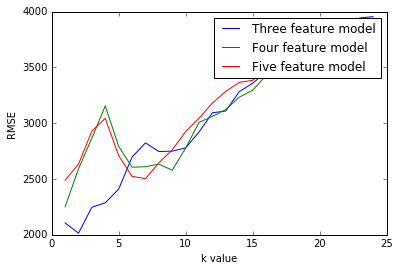

In [115]:
for k,v in rmses.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.legend(["Three feature model", "Four feature model", "Five feature model"])

The optimal `k` value id 2 for the Three-feature model, and 1 for the Four-feature and Five-feature model.

Our Three-feature model has seen a significant increase on its performance, however with a RMSE slightly above 2000 dollars, it is still very unreliable. Also, we haven't calculated the variance of the error: we don't really know if it performs OK for a particular kind of cars and poorly for the rest, or if it predicts 